# **Finance Pairs Formation**

# **Import libraries and dataset**

In [1]:
import numpy as np
import pandas as pd
import statsmodels
from statsmodels.tsa.stattools import coint, adfuller
import statistics as stats
import plotly.graph_objects as go
import missingno as msno
import plotly.express as px
import plotly.figure_factory as ff
import itertools
from heapq import nsmallest, nlargest
import matplotlib.pyplot as plt
import seaborn as sns
import more_itertools
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(20,14)})

In [2]:
import sys
# locate the folder which stores the custom package using relative path
sys.path.append('../../../../../src')

import config_snippets as config_snp
import splitting_data as splitting_data
import gatev_distance_method as gatev_dist
import data_transformation_snippets as data_transform_snp
import time_series_analysis_snippets as tsa_snp
import engle_granger_cointegration_method as eg_coint
import johansen_cointegration_method as jj_coint 
import handling_dataframe as hdf
import handling_datetime as hdt

In [3]:
# Path to your config YAML file
config_file_path = "..//..//../config.yaml"

# Load the configuration
config = config_snp.load_config(config_file_path)

if config is not None:
    import ast
    # Access and use the parameters
    split_ratio = config.get("split_ratio")
    
    # Access and convert string to tuple
    train_period = ast.literal_eval(config.get("train_period"))
    test_period = ast.literal_eval(config.get("test_period"))
    
    # Get list of df_tech data paths
    lst_df_tech_paths = ast.literal_eval(config.get("paths_df_tech_processed"))
    

In [4]:
# Import data 
path = lst_df_tech_paths[2]
df = pd.read_csv(path)

In [5]:
# Set date as index
df.set_index("date", inplace=True)

In [6]:
df = df.dropna()

# **Split data**

In [7]:
# Example: split ratio = 0.7
df_train, df_test = splitting_data.splitting_data_by_ratio(
    df,
    split_ratio=split_ratio
)

In [8]:
# Example of splitting by specified period

# test_train, test_test = splitting_data_by_date(
#     df,
#     train_period = train_period,
#     test_period = test_period
# )

# **Gatev Distance Approach**

In [9]:
df_train

,adClose_DXG,adClose_HAG,adClose_HQC,adClose_ITA,adClose_MBB,adClose_SHB,adClose_SSI,adClose_STB,adClose_VND,adClose_VPB
date,,,,,,,,,,
2021-11-30,32.70,8.23,6.48,13.20,20.498,17.315,48.586,28.9,31.383,25.134
2021-12-01,33.25,8.70,6.65,13.35,20.851,17.352,47.978,29.9,30.985,25.267
2021-12-02,32.20,8.80,6.87,13.05,20.568,17.352,46.935,29.3,30.867,24.667
2021-12-03,31.10,8.80,6.70,13.00,20.003,16.947,43.893,28.0,28.999,23.800
2021-12-04,31.10,8.80,6.70,13.00,20.003,16.947,43.893,28.0,28.999,23.800
...,...,...,...,...,...,...,...,...,...,...
2023-02-16,11.15,8.00,2.87,4.13,15.480,8.559,18.761,23.9,14.600,17.500
2023-02-17,11.15,7.96,2.84,4.11,15.353,8.559,18.713,24.4,14.450,17.300
2023-02-18,11.15,7.96,2.84,4.11,15.353,8.559,18.713,24.4,14.450,17.300


## **Gatev Data Normalization**

In [10]:
df_cum_daily_returns_train = gatev_dist.gatev_data_normalize(df_train)

In [11]:
df_cum_daily_returns_train

,adClose_DXG,adClose_HAG,adClose_HQC,adClose_ITA,adClose_MBB,adClose_SHB,adClose_SSI,adClose_STB,adClose_VND,adClose_VPB
date,,,,,,,,,,
2021-12-01,1.681957,5.710814,2.623457,1.136364,1.722119,0.213688,-1.251389,3.460208,-1.268203,0.529164
2021-12-02,-1.529052,6.925881,6.018519,-1.136364,0.341497,0.213688,-3.398098,1.384083,-1.644202,-1.858041
2021-12-03,-4.892966,6.925881,3.395062,-1.515152,-2.414870,-2.125325,-9.659161,-3.114187,-7.596469,-5.307552
2021-12-04,-4.892966,6.925881,3.395062,-1.515152,-2.414870,-2.125325,-9.659161,-3.114187,-7.596469,-5.307552
2021-12-05,-4.892966,6.925881,3.395062,-1.515152,-2.414870,-2.125325,-9.659161,-3.114187,-7.596469,-5.307552
...,...,...,...,...,...,...,...,...,...,...
2023-02-16,-65.902141,-2.794654,-55.709877,-68.712121,-24.480437,-50.568871,-61.385996,-17.301038,-53.477998,-30.373200
2023-02-17,-65.902141,-3.280680,-56.172840,-68.863636,-25.100010,-50.568871,-61.484790,-15.570934,-53.955963,-31.168935
2023-02-18,-65.902141,-3.280680,-56.172840,-68.863636,-25.100010,-50.568871,-61.484790,-15.570934,-53.955963,-31.168935


## **Gatev Distance Approach Pairs Formation**

In [12]:
gatev_dist.gatev_distance_matrix(df_cum_daily_returns_train)

In [13]:
gatev_pairs, list_result_smallest_dist = gatev_dist.gatev_distance_smallest(
    df=df_cum_daily_returns_train,
    top_values=10
)

In [14]:
for res in list_result_smallest_dist:
    print(res)
    
print(gatev_pairs)

Khoảng cách Euclide của adClose_DXG và adClose_HQC: 246.5
Khoảng cách Euclide của adClose_DXG và adClose_ITA: 324.3
Khoảng cách Euclide của adClose_DXG và adClose_VND: 312.6
Khoảng cách Euclide của adClose_HQC và adClose_ITA: 264.2
Khoảng cách Euclide của adClose_MBB và adClose_STB: 210.3
Khoảng cách Euclide của adClose_MBB và adClose_VPB: 221.1
Khoảng cách Euclide của adClose_SHB và adClose_SSI: 287.8
Khoảng cách Euclide của adClose_SHB và adClose_VND: 209.1
Khoảng cách Euclide của adClose_STB và adClose_VPB: 244.3
Khoảng cách Euclide của adClose_VND và adClose_VPB: 354.2
[['adClose_DXG', 'adClose_HQC'], ['adClose_DXG', 'adClose_ITA'], ['adClose_DXG', 'adClose_VND'], ['adClose_HQC', 'adClose_ITA'], ['adClose_MBB', 'adClose_STB'], ['adClose_MBB', 'adClose_VPB'], ['adClose_SHB', 'adClose_SSI'], ['adClose_SHB', 'adClose_VND'], ['adClose_STB', 'adClose_VPB'], ['adClose_VND', 'adClose_VPB']]


In [15]:
gatev_pairs

[['adClose_DXG', 'adClose_HQC'],
 ['adClose_DXG', 'adClose_ITA'],
 ['adClose_DXG', 'adClose_VND'],
 ['adClose_HQC', 'adClose_ITA'],
 ['adClose_MBB', 'adClose_STB'],
 ['adClose_MBB', 'adClose_VPB'],
 ['adClose_SHB', 'adClose_SSI'],
 ['adClose_SHB', 'adClose_VND'],
 ['adClose_STB', 'adClose_VPB'],
 ['adClose_VND', 'adClose_VPB']]

# **Cointegration Approach**

## **Data Transformation**

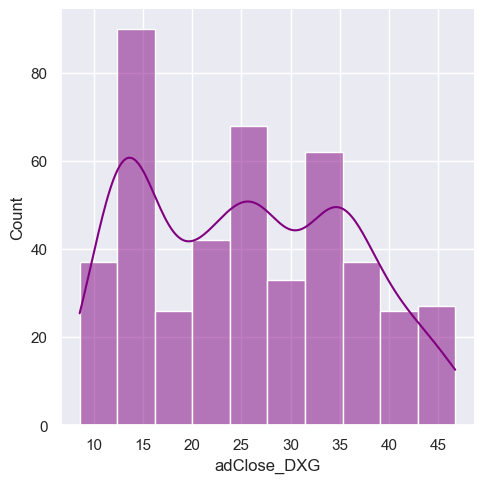

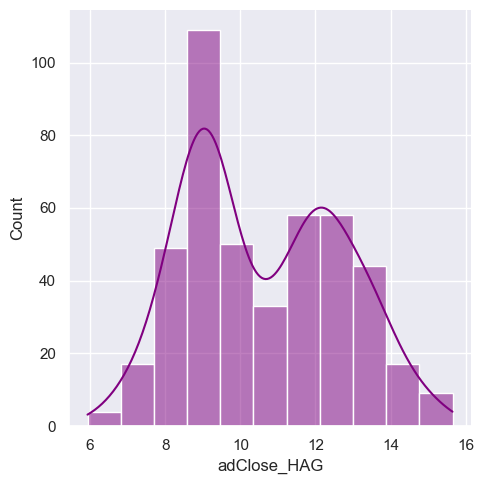

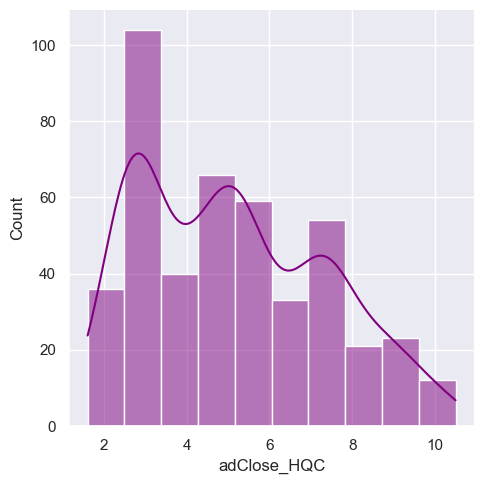

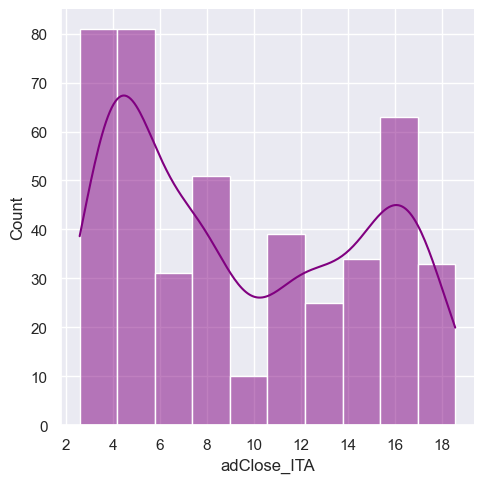

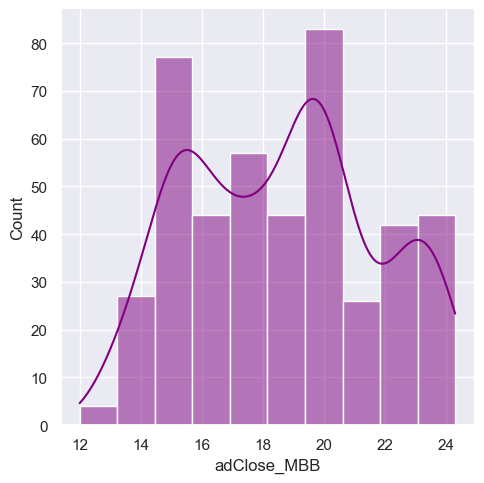

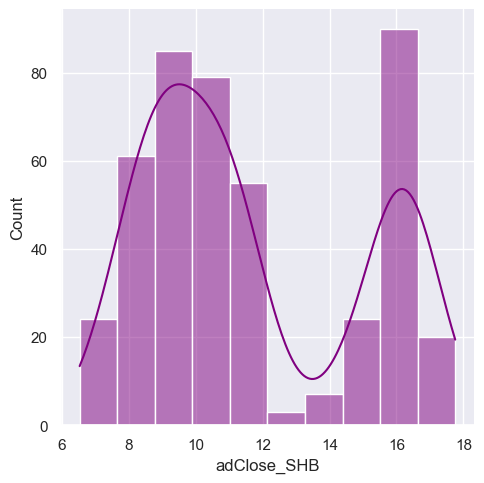

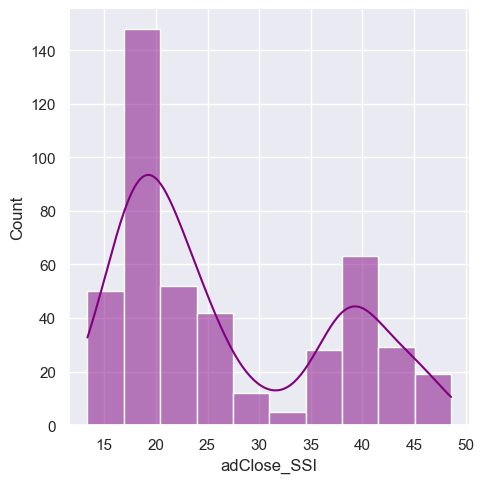

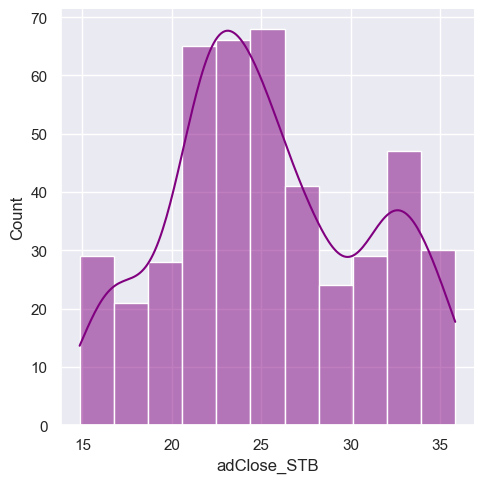

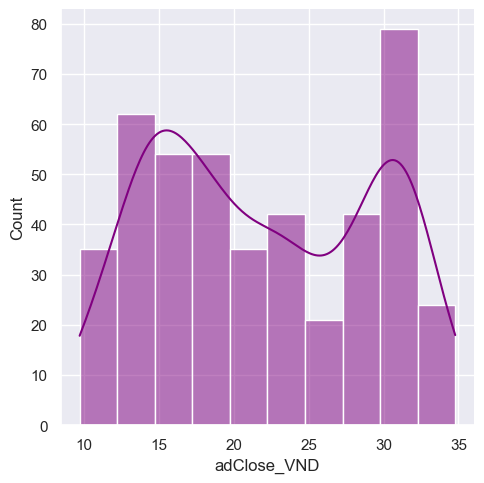

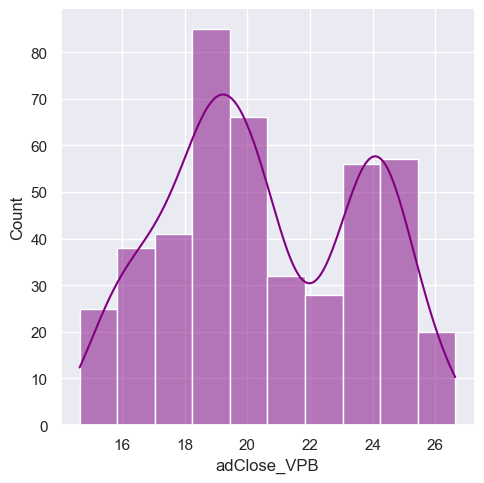

In [16]:
# Visualize distribution of values of each stock
data_transform_snp.dist_stock_visualization(df_train)

In [17]:
# Take natural log transformation of the data  
df_train_transformed = data_transform_snp.df_natural_log_transformed(df_train)

In [18]:
# Visualize distribution of transformed values of each stock
data_transform_snp.dist_stock_visualization(df_train_transformed)

## **Pretesting Stationary**

In [19]:
tsa_snp.find_integration_order(df_train_transformed)

,Column Name,Integration Order
0,adClose_DXG,1
1,adClose_HAG,1
2,adClose_HQC,1
3,adClose_ITA,1
4,adClose_MBB,1
5,adClose_SHB,1
6,adClose_SSI,1
7,adClose_STB,1
8,adClose_VND,1
9,adClose_VPB,1


## **Engle - Grange Method**

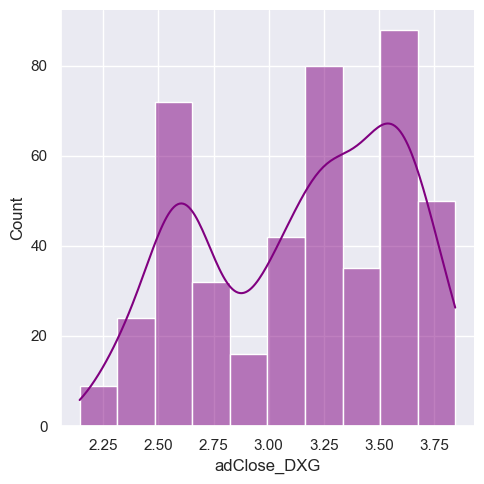

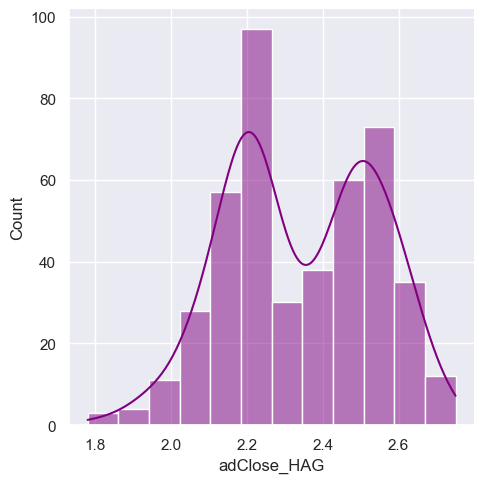

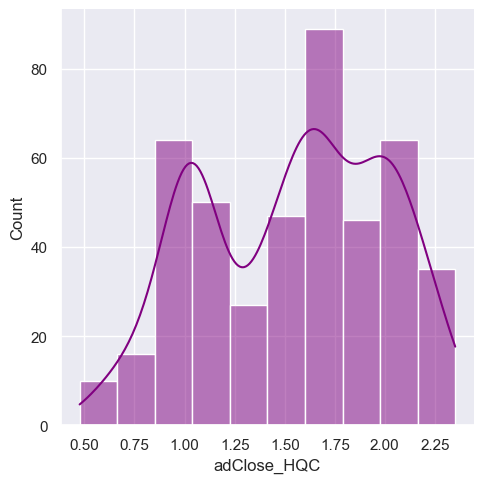

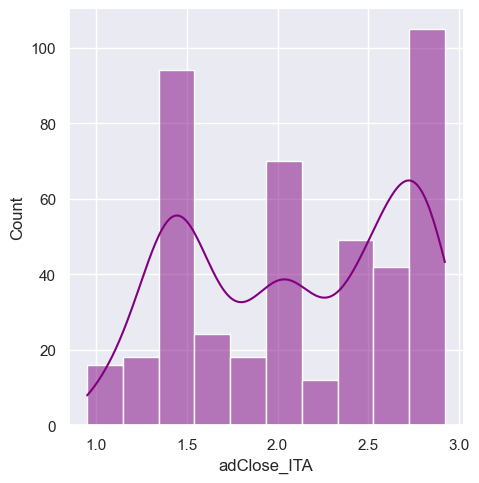

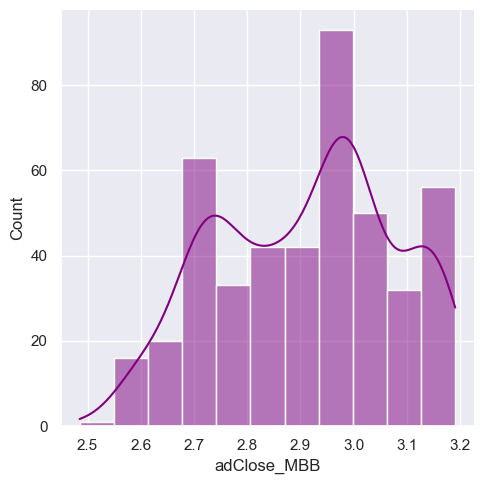

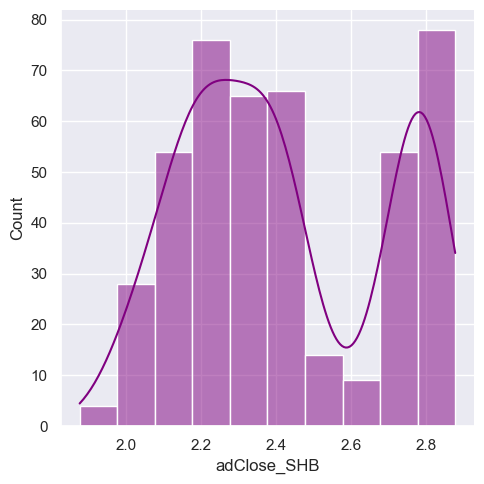

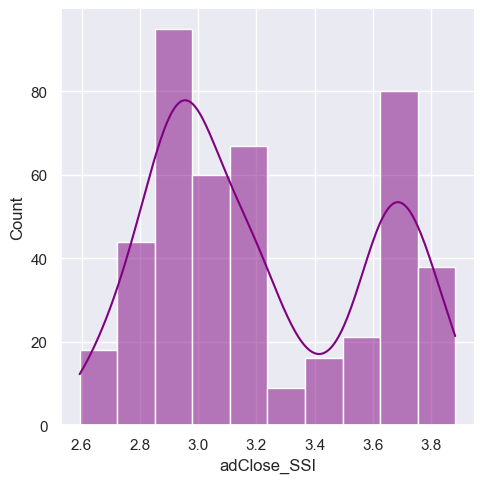

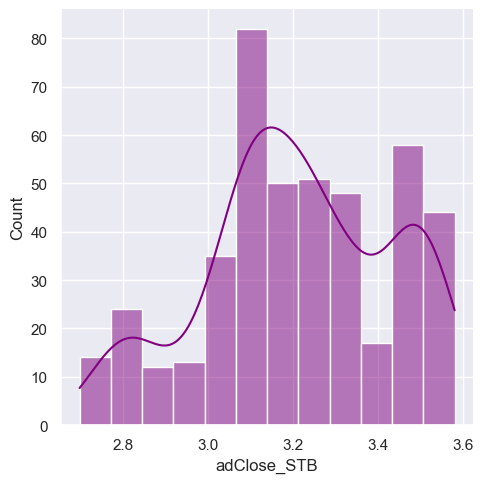

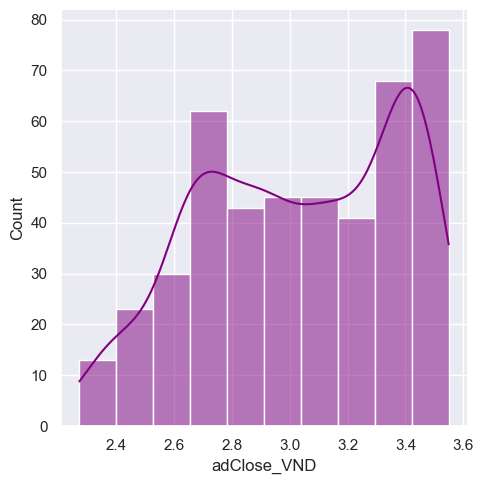

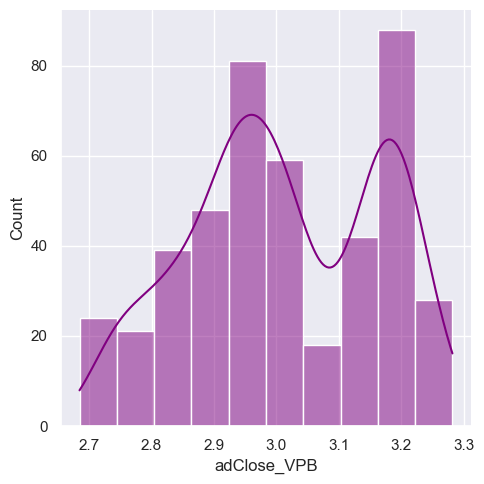

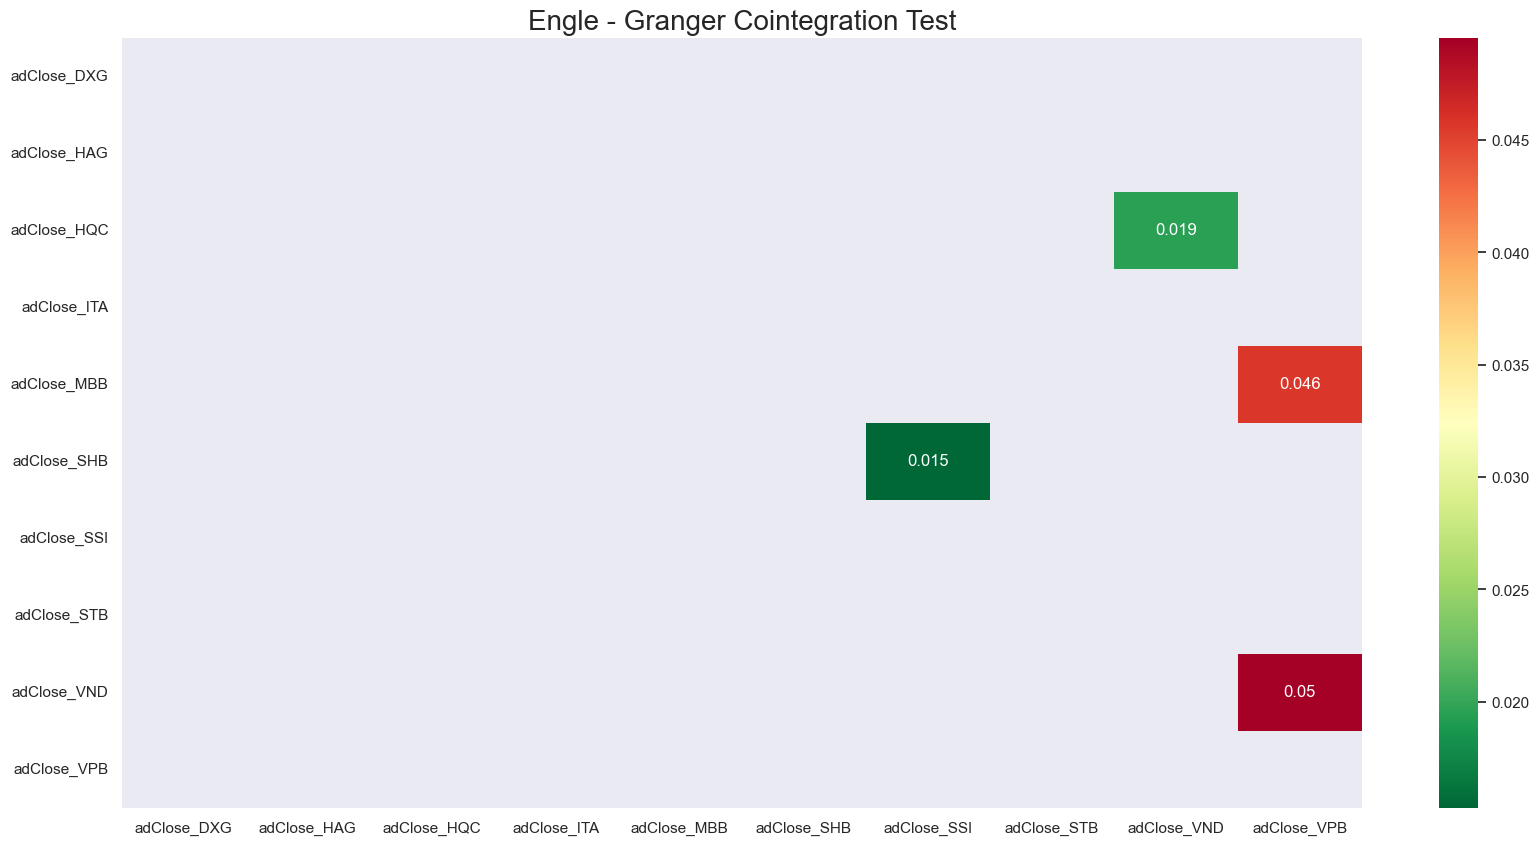

In [20]:
score_matrix, pvalue_matrix, eg_pairs = eg_coint.find_cointegrated_pairs(df_train_transformed)

In [21]:
eg_pairs 

[['adClose_HQC', 'adClose_VND'],
 ['adClose_MBB', 'adClose_VPB'],
 ['adClose_SHB', 'adClose_SSI'],
 ['adClose_VND', 'adClose_VPB']]

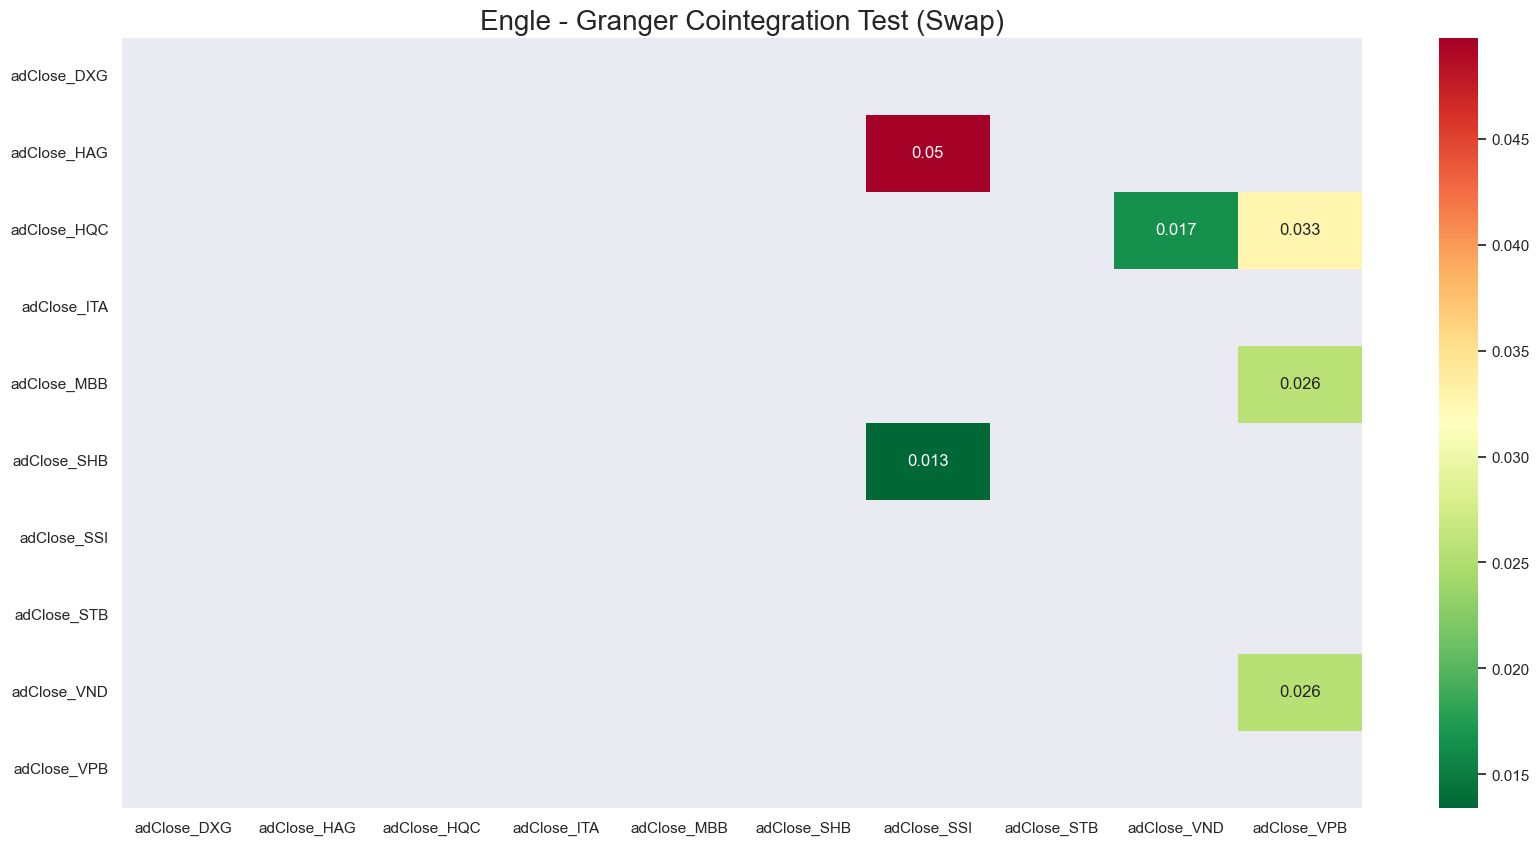

In [22]:
scores_swap, pvalues_swap, eg_pairs_swap = eg_coint.find_cointegrated_pairs_swap(df_train_transformed)

In [23]:
eg_pairs_swap

[['adClose_HAG', 'adClose_SSI'],
 ['adClose_HQC', 'adClose_VND'],
 ['adClose_HQC', 'adClose_VPB'],
 ['adClose_MBB', 'adClose_VPB'],
 ['adClose_SHB', 'adClose_SSI'],
 ['adClose_VND', 'adClose_VPB']]

## **Johansen Method**

In [24]:
johansen_pairs = jj_coint.johansen_test(df_train_transformed)

In [25]:
johansen_pairs

[['adClose_ITA', 'adClose_SSI'],
 ['adClose_SHB', 'adClose_SSI'],
 ['adClose_SHB', 'adClose_VPB'],
 ['adClose_SSI', 'adClose_VND']]

# **Result Summary**

In [26]:
df_pairs_formation_train = hdf.pairs_formation_result_summary(
    gatev_pairs,
    eg_pairs,
    eg_pairs_swap,
    johansen_pairs
)

In [27]:
df_pairs_formation_train

,Stock A,Stock B,Gatev Pairs,EG Pairs,EG Pairs Swap,Johansen Pairs,Count
0,adClose_DXG,adClose_HQC,x,,,,1
1,adClose_DXG,adClose_ITA,x,,,,1
2,adClose_DXG,adClose_VND,x,,,,1
3,adClose_HAG,adClose_SSI,,,x,,1
4,adClose_HQC,adClose_ITA,x,,,,1
5,adClose_HQC,adClose_VND,,x,x,,2
6,adClose_HQC,adClose_VPB,,,x,,1
7,adClose_ITA,adClose_SSI,,,,x,1
8,adClose_MBB,adClose_STB,x,,,,1
9,adClose_MBB,adClose_VPB,x,x,x,,3


In [29]:
df_pairs_formation_train.to_csv(
    f"..//..//..//..//..//results//pairs_formation//tech//tech_pairs_formation_third_period_{hdt.today_date_to_digits()}.csv"
    )